# Solving Crimes with Data Science
<br/>
<br/>
<br/>
<b>Markus Harrer</b>
  
`@feststelltaste`


<small>PyDay 1, 19. Dezember 2019</small>

<img src="resources/innoq_logo.jpg" width=20% height="20%" align="right"/>


## Facts of the case
- a white bus with a red "g" sign on the side window was stolen
- police did an innovative mpbile phone investigation
- there was only phone number of unknown identity: +14638472273

Our approach: Where are the whereabouts / place of residence of the mobile phone owner?

## What do we have?

CDRs (Call Data Records) in an Excel file!

That means: Information about the cell towers used for the phone calls!



## Import and Load
Using pandas to read an Excel file into a Dataframe.

In [1]:
import pandas as pd
cdr = pd.read_excel("cdr_data.xlsx")
cdr.head()

,Caller,Callee,Event,Start,TowerID
0,4638472273,2666307251,Incoming,2010-12-25 07:16:24.736813,0db53dd3
1,4638472273,1755442610,Incoming,2010-12-25 21:18:30.053710,aeaf8b43
2,4638472273,5481755331,Incoming,2010-12-25 14:52:42.878016,fadaa83f
3,4638472273,1755442610,Incoming,2010-12-25 16:02:09.001913,fadaa83f
4,4638472273,2145623768,Incoming,2010-12-25 15:28:35.028554,95d7920d


Let's look into the dataset

In [2]:
cdr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53185 entries, 0 to 53184
Data columns (total 5 columns):
Caller     53185 non-null int64
Callee     53185 non-null int64
Event      53185 non-null object
Start      53185 non-null object
TowerID    53185 non-null object
dtypes: int64(2), object(3)
memory usage: 2.0+ MB


## Data Cleaning
Convert the text in `Start` to a date data type

In [3]:
cdr['Start'] = pd.to_datetime(cdr['Start'])
cdr.head()

,Caller,Callee,Event,Start,TowerID
0,4638472273,2666307251,Incoming,2010-12-25 07:16:24.736813,0db53dd3
1,4638472273,1755442610,Incoming,2010-12-25 21:18:30.053710,aeaf8b43
2,4638472273,5481755331,Incoming,2010-12-25 14:52:42.878016,fadaa83f
3,4638472273,1755442610,Incoming,2010-12-25 16:02:09.001913,fadaa83f
4,4638472273,2145623768,Incoming,2010-12-25 15:28:35.028554,95d7920d


## Filtering
We know the suspect's phone number (4638472273) and the `TowerID` of the `Caller`

In [4]:
suspect = cdr[cdr['Caller'] == 4638472273]
suspect = suspect[suspect['Event'] == 'Incoming']
suspect.head()

,Caller,Callee,Event,Start,TowerID
0,4638472273,2666307251,Incoming,2010-12-25 07:16:24.736813,0db53dd3
1,4638472273,1755442610,Incoming,2010-12-25 21:18:30.053710,aeaf8b43
2,4638472273,5481755331,Incoming,2010-12-25 14:52:42.878016,fadaa83f
3,4638472273,1755442610,Incoming,2010-12-25 16:02:09.001913,fadaa83f
4,4638472273,2145623768,Incoming,2010-12-25 15:28:35.028554,95d7920d


## But...

Unfortunately: Information about the tower's locations are missing!

We need a second data source from the DARKNET!

## Load another dataset
This time: a CSV file

In [5]:
towers = pd.read_csv("darknet.io/hacks/infrastructure/mobile_net/texas_towers.csv", index_col=0)
towers.head()

,TowerLat,TowerLon
TowerID,,
0db53dd3,32.731611,-96.709417
aeaf8b43,32.731722,-96.709500
fadaa83f,32.899944,-96.910389
95d7920d,32.899944,-96.910389
95c91e8b,32.899944,-96.910389


## Join
Bringing datasets together

In [6]:
suspect_loc = suspect.join(towers, on='TowerID')
suspect_loc.head()

,Caller,Callee,Event,Start,TowerID,TowerLat,TowerLon
0,4638472273,2666307251,Incoming,2010-12-25 07:16:24.736813,0db53dd3,32.731611,-96.709417
1,4638472273,1755442610,Incoming,2010-12-25 21:18:30.053710,aeaf8b43,32.731722,-96.709500
2,4638472273,5481755331,Incoming,2010-12-25 14:52:42.878016,fadaa83f,32.899944,-96.910389
3,4638472273,1755442610,Incoming,2010-12-25 16:02:09.001913,fadaa83f,32.899944,-96.910389
4,4638472273,2145623768,Incoming,2010-12-25 15:28:35.028554,95d7920d,32.899944,-96.910389


## Explore the data
Let's take a look at the locations

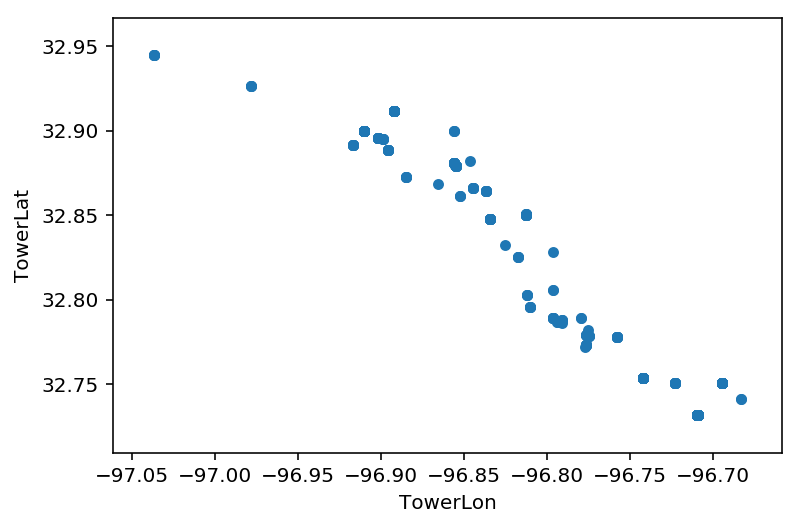

In [7]:
suspect_loc.plot.scatter('TowerLon', "TowerLat");

## Modeling
Make some hypothesis about the suspect's home

#### Hypothesis 1: Home at weekends

In [8]:
suspect_loc['DoW'] = suspect_loc['Start'].dt.weekday_name
suspect_loc.head()

,Caller,Callee,Event,Start,TowerID,TowerLat,TowerLon,DoW
0,4638472273,2666307251,Incoming,2010-12-25 07:16:24.736813,0db53dd3,32.731611,-96.709417,Saturday
1,4638472273,1755442610,Incoming,2010-12-25 21:18:30.053710,aeaf8b43,32.731722,-96.709500,Saturday
2,4638472273,5481755331,Incoming,2010-12-25 14:52:42.878016,fadaa83f,32.899944,-96.910389,Saturday
3,4638472273,1755442610,Incoming,2010-12-25 16:02:09.001913,fadaa83f,32.899944,-96.910389,Saturday
4,4638472273,2145623768,Incoming,2010-12-25 15:28:35.028554,95d7920d,32.899944,-96.910389,Saturday


In [9]:
suspect_on_weekend = suspect_loc[suspect_loc['DoW'].isin(['Saturday', 'Sunday'])].copy()
suspect_on_weekend.head()

,Caller,Callee,Event,Start,TowerID,TowerLat,TowerLon,DoW
0,4638472273,2666307251,Incoming,2010-12-25 07:16:24.736813,0db53dd3,32.731611,-96.709417,Saturday
1,4638472273,1755442610,Incoming,2010-12-25 21:18:30.053710,aeaf8b43,32.731722,-96.709500,Saturday
2,4638472273,5481755331,Incoming,2010-12-25 14:52:42.878016,fadaa83f,32.899944,-96.910389,Saturday
3,4638472273,1755442610,Incoming,2010-12-25 16:02:09.001913,fadaa83f,32.899944,-96.910389,Saturday
4,4638472273,2145623768,Incoming,2010-12-25 15:28:35.028554,95d7920d,32.899944,-96.910389,Saturday


Let's take a look at the weekend's locations

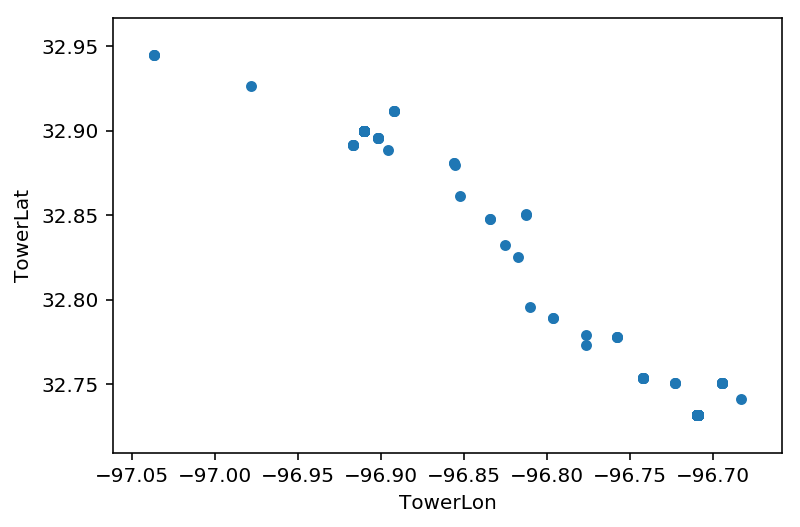

In [10]:
suspect_on_weekend.plot.scatter('TowerLon', "TowerLat");

#### Hypothesis 2: Sleeping at night

In [11]:
suspect_on_weekend['hour'] = suspect_on_weekend['Start'].dt.hour
suspect_on_weekend.head()

,Caller,Callee,Event,Start,TowerID,TowerLat,TowerLon,DoW,hour
0,4638472273,2666307251,Incoming,2010-12-25 07:16:24.736813,0db53dd3,32.731611,-96.709417,Saturday,7
1,4638472273,1755442610,Incoming,2010-12-25 21:18:30.053710,aeaf8b43,32.731722,-96.709500,Saturday,21
2,4638472273,5481755331,Incoming,2010-12-25 14:52:42.878016,fadaa83f,32.899944,-96.910389,Saturday,14
3,4638472273,1755442610,Incoming,2010-12-25 16:02:09.001913,fadaa83f,32.899944,-96.910389,Saturday,16
4,4638472273,2145623768,Incoming,2010-12-25 15:28:35.028554,95d7920d,32.899944,-96.910389,Saturday,15


Keep only the sleeping hours

In [12]:
suspect_on_weekend_night = suspect_on_weekend[
    (suspect_on_weekend['hour'] < 6)  | (suspect_on_weekend['hour'] > 22)]
suspect_on_weekend_night.head()

,Caller,Callee,Event,Start,TowerID,TowerLat,TowerLon,DoW,hour
7468,4638472273,7756914135,Incoming,2011-04-17 05:15:40.205917,cd9f3b1a,32.731722,-96.709500,Sunday,5
9753,4638472273,7922223441,Incoming,2011-05-21 05:08:20.121145,0db53dd3,32.731611,-96.709417,Saturday,5
17515,4638472273,2666307251,Incoming,2011-09-11 05:44:15.432523,bcec0121,32.731611,-96.709417,Sunday,5
31973,4638472273,1755442610,Incoming,2012-04-14 05:42:32.004437,d760c426,32.731611,-96.709417,Saturday,5
32604,4638472273,7922223441,Incoming,2012-04-22 05:02:55.678110,8ba7e0d7,32.731611,-96.709417,Sunday,5


Let's see where the suspect sleeps on weekends

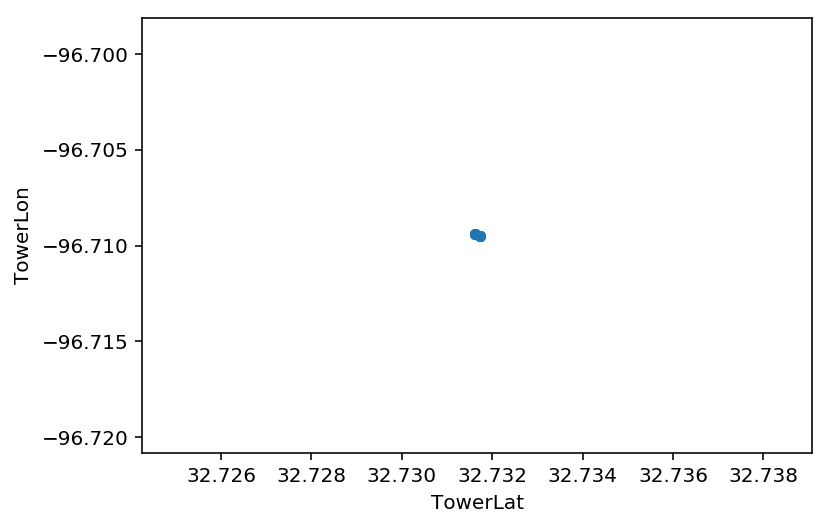

In [13]:
ax = suspect_on_weekend_night.plot.scatter('TowerLat', 'TowerLon')

#### Clustering
* Cell phones connect to various towers over time
* Therefore: Find the main center of his sleeping activities

In [14]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 1)
data = suspect_on_weekend_night[['TowerLat', 'TowerLon']]
kmeans.fit_predict(data)
centroids = kmeans.cluster_centers_
centroids

array([[ 32.7316665, -96.7094585]])

Let's plot the main center of sleeping activity.

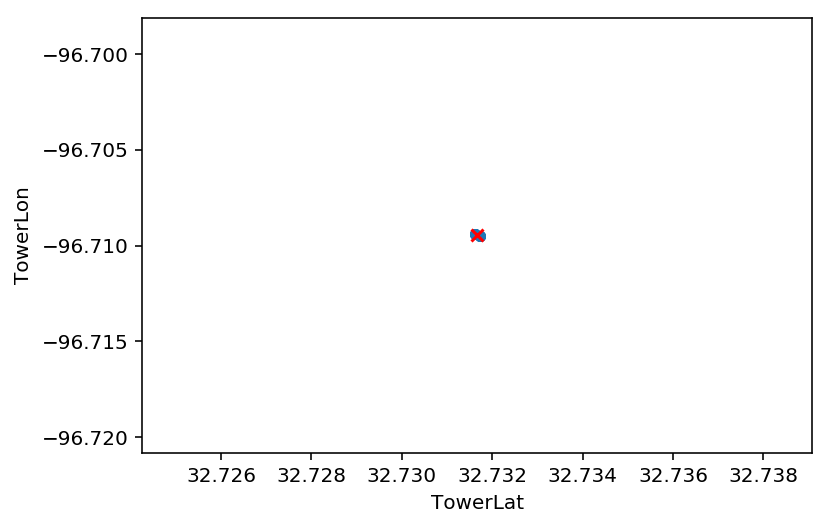

In [15]:
ax.scatter(x = centroids[:, 0], y = centroids[:, 1], c = 'r', marker = 'x')
ax.figure

## Results
Let's check the result in Google Maps!

In [17]:
print("https://www.google.com/maps/search/?api=1&query={},{}".format(centroids[0][0], centroids[0][1]))

https://www.google.com/maps/search/?api=1&query=32.7316665,-96.70945850000001


## Thanks!

Any questions?

<br/>
  
<b>Contact</b>

Markus Harrer  
  
markus.harrer@innoq.com  
`@feststelltaste`  
https://feststelltaste.de

<img src="resources/innoq_logo.jpg" width=20% height="20%" align="right"/>

## Appendix: Tools used
- Jupyter Notebook
- Python
- pandas
- matplotlib
- scikit-learn

## Appendix: Getting started
My recommendations

1. https://www.feststelltaste.de/top5-jupyter/
1. https://www.feststelltaste.de/top5-python/
1. https://www.feststelltaste.de/top5-pandas/    

## Appendix: Credits

This presentation is based on data and ideas from the online course "Programming with Python for Data Science": https://www.edx.org/course/programming-with-python-for-data-science